In [1]:
import sys
# путь к коду среды
sys.path.append("../")
#sys.path.append("/s/ls4/users/grartem/RL_robots/RL_robotSim/")
import os
# если я правильно помню, без такой переменной gym будет пытаться отрендерить изображение на гпу и могут возникнуть проблемы на кластере.
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
import time
import gym
import pyhocon
import numpy as np
import pandas as pd
import ray
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ddpg.td3 import TD3Trainer
import pygame
import matplotlib.pyplot as plt
%matplotlib inline

import continuous_grid_arctic.follow_the_leader_continuous_env
from continuous_grid_arctic.utils.wrappers import MyFrameStack, ContinuousObserveModifier_v0, ContinuousObserveModifier_lidarMap2d, ContinuousObserveModifier_lidarMap2d_v2, LeaderTrajectory_v0
from ray.tune import register_env

pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
def continuous_env_maker(config):
    """
    Функция создающая среду для робота по переданному конфигу.
    В конфиге должны быть поля:
     - name - имя среды, под которым она была зарегистрирована через gym_register. # сейчас регистрация происходит при импорте follow_the_leader_continuous_env
     - base_env_config - словарь с аргументами, которые будут переданы в конструктор класса gym среды
     - wrappers - список названий классов обёрток, которые будут добавлены к среде для обработки наблюдений и экшенов.
    """
    name = config["name"]
    action_values_range = config.get("action_values_range", None)
    env = gym.make(name, **config["base_env_config"])
    if 'ContinuousObserveModifier_v0' in config["wrappers"]:
        env = ContinuousObserveModifier_v0(env, action_values_range)    
    return env

register_env("continuous-grid", continuous_env_maker)

In [4]:
env_config = {
    'name' : 'Test-Cont-Env-Auto-v0',  #  имя среды, под которым она была зарегистрирована через gym_register. # сейчас регистрация происходит при импорте follow_the_leader_continuous_env, посмотреть доступные названия можно в follow_the_leader_continuous_env.py
    'wrappers': ['ContinuousObserveModifier_v0'],  # список названий классов обёрток, которые будут добавлены к среде для обработки наблюдений и экшенов.
    'base_env_config' : {  # словарь с аргументами, которые будут переданы в конструктор класса gym среды
        'add_obstacles': True,  # наличие препятствий в среде
        'max_distance': 4,  # максимальная дистанция, на которую может отстать ведомый (метры)
        'warm_start': 0,  # количество шагов, в течение которых не начислаются награды и штрафы
        'max_steps': 10000,  # количество шагов, после которого остановится симуляция
        'framerate': 5000,  # ? максимальная частота шагов?
        'obstacle_number': 35,  # количество камней
        'constant_follower_speed': False,  # зафиксировать скорость ведомого и оставить только 1 действие - поворот
        'corridor_length': 10,  # длина коридора сейф зоны (с точки зрения признака, но не награды)  # !!! вообще это должен быть параметр сенсора
        'corridor_width': 1.5,  # ширина коридора сейф зоны (с точки зрения признака, но не награды)  # !!! вообще это должен быть параметр сенсора
        'move_bear_v4': True,  #?
        'follower_speed_koeff': 0.6,  # коэффициент скорости ведомого
        'leader_speed_coeff': 0.45,  # коэффициент скорости лидера
        'negative_speed': True,  # можно ли двигаться назад
        'add_bear': True,  # добавлять ли медведя (динамическое препатствие)
        'bear_number': 1,  # количество динамических препятствий
        'bear_speed_coeff': 1.2,  # коэффициент скорости медведя                
        'multi_random_bears': False,  # ?
        'bear_behind': False,  # ?
        'use_prev_obs': True,  # использовать предыдущие наблюдения
        'max_prev_obs': 5,  # количество предыдущих наблюдений
        'early_stopping' : {  # когда стоит останавливать симуляцию (помимо максимального количества шагов)
            'max_distance_coef': 3.5,  # когда ведомый удалится от лидера больше чем на max_distance*max_distance_coef метров
            'low_reward': -300  # когда суммарная награда опустится ниже этого значения
        },
        'random_frames_per_step': [2, 20],  # количество фреймов (изменений происходящих в среде) на один шаг (принятие решения)
        'leader_speed_regime': {  # расписание коэффициентов скорости лидера
            '0': [0.2, 1],
            '200': 1,
            '1000': [0.5, 1],
            '1500': 0.75,
            '2000': 0,
            '2500': 1,
            '3000': [0.5, 1],
            '4000': [0.0, 0.5],
            '5000': [0.4, 1]
        },
        'follower_sensors': {  # активные сенсоры ведомого и их настройки
            'LeaderPositionsTracker_v2': {  
                'eat_close_points': False,
                'generate_corridor': True,
                'saving_period': 8,
                'sensor_name': 'LeaderPositionsTracker_v2',
                'start_corridor_behind_follower': True,
            },
            'LeaderCorridor_Prev_lasers_v2': {
                'sensor_name': 'LeaderCorridor_Prev_lasers_v2',
                'react_to_obstacles':  True,
                'react_to_safe_corridor': True,
                'react_to_green_zone': True,
                'front_lasers_count': 6,
                'back_lasers_count': 6,
                'laser_length': 150
            },
            'LaserPrevSensor': {
                'sensor_name': 'LaserPrevSensor',
                'react_to_obstacles': True,
                'react_to_safe_corridor': False,
                'react_to_green_zone': False,
                'front_lasers_count': 15,
                'back_lasers_count':15,
                'laser_length': 200
            }
        },
    }
    
}

In [5]:
env = continuous_env_maker(env_config)  # создаём среду по конфигу

../continuous_grid_arctic/follow_the_leader_continuous_env.py:331: UserWarning: Одновременно заданы и random_frames_per_step и frames_per_step, будет использоваться random_frames_per_step
  warn(
/s/ls4/users/grartem/anaconda3/envs/rl_robots/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [6]:
env.seed(12)  # задаем рандом сид, если хотим запустить зафиксированный вариант расположения объектов
ret = env.reset()  # перезапускаем среду 

===Запуск симуляции номер 0===


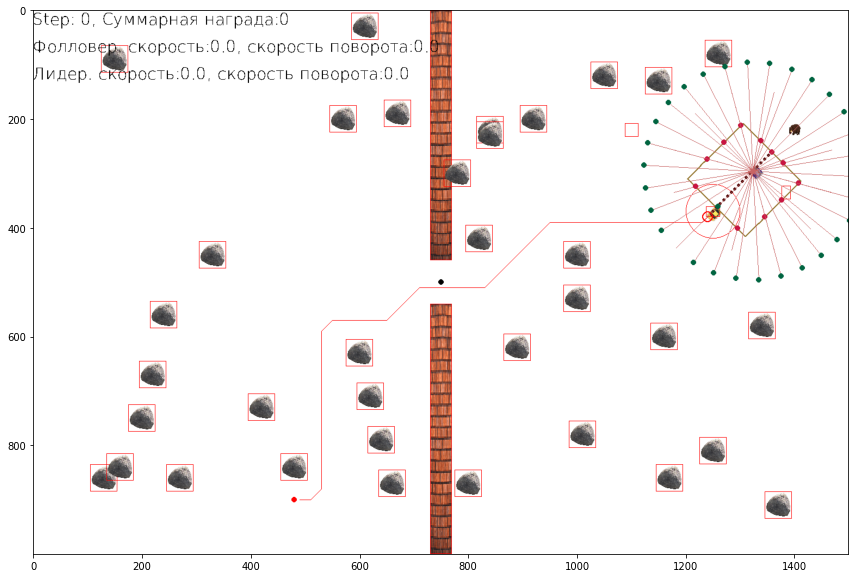

In [7]:
# рисуем текущее состояние среды
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))

In [8]:
env.action_space  # диапазоны значений для действий

Box([-0.3     -0.57296], [0.3     0.57296], (2,), float32)

In [9]:
# тестируем функцию обработки действий
for i in range(10):
    obs, reward, isDone, info  = env.step(action=[0.3,0.00])
    print(reward, isDone, info)

1.0 False {'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}
1.0 False {'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}
1.0 False {'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}
1.0 False {'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}
1.0 False {'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}
1.0 False {'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}
1.0 False {'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}
1.0 False {'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}
1.0 False {'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}
1.0 False {'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}


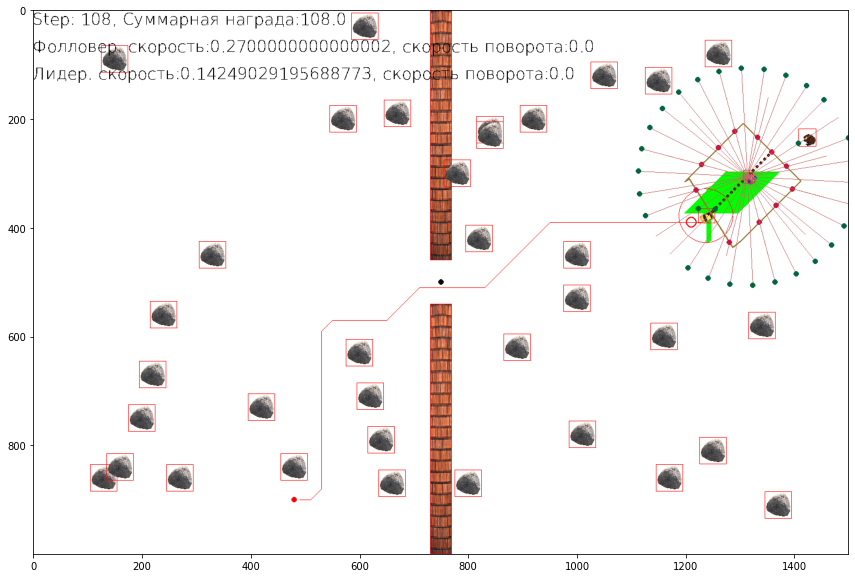

In [10]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))